In [ ]:
%%capture
# Cài đặt Unsloth và các thư viện cần thiết
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.27" "trl<0.9.0" peft accelerate bitsandbytes

In [ ]:
import torch
import psutil
import os
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments, AutoTokenizer
from datasets import Dataset
import json
from datasets import load_dataset
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import userdata
token_Huggingface = userdata.get('HF_TOKEN')

In [ ]:
# --- 1. Đường dẫn đến dữ liệu trên Google Drive ---
SFT_DATASET_PATH = "/content/drive/MyDrive/chatbot_project/sft_dataset/sft_dataset.jsonl"
OUTPUT_DIR = "/content/drive/MyDrive/chatbot_project/llm_finetuned_ver2"

# Kiểm tra xem file có tồn tại không để tránh lỗi sau này
if not os.path.exists(SFT_DATASET_PATH):
    raise FileNotFoundError(f"Không tìm thấy file tại: {SFT_DATASET_PATH}")

# --- 2. Chuẩn bị Dữ liệu Huấn luyện (CÁCH SỬA LỖI) ---
# Sử dụng load_dataset với định dạng "json" sẽ tự động xử lý file .jsonl rất tốt
dataset = load_dataset("json", data_files=SFT_DATASET_PATH, split="train")

# Chia tập train/test
dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

# In thông tin kiểm tra
print(f"Số lượng mẫu huấn luyện: {len(train_dataset)}")
print(f"Số lượng mẫu kiểm tra: {len(eval_dataset)}")
print("Mẫu dữ liệu đầu tiên:")
print(train_dataset[0])

Generating train split: 0 examples [00:00, ? examples/s]

Số lượng mẫu huấn luyện: 900
Số lượng mẫu kiểm tra: 100
Mẫu dữ liệu đầu tiên:
{'instruction': 'Có bắt buộc giảng viên phải dùng công cụ trình chiếu trong video không?', 'input': 'Bạn là chatbot hỏi đáp quy chế sinh viên.\nChỉ sử dụng thông tin trong CONTEXT bên dưới.\n\nCONTEXT:\n---\nVăn bản: Quy định dạy-học trực tuyến\nPhụ lục: 1\nMục: 3.a\n\nNội dung:\n...nếu có sử dụng công cụ trình chiếu...\n---\n', 'output': 'Theo Phụ lục 1, Mục 3.a, từ Quy định dạy-học trực tuyến, việc sử dụng công cụ trình chiếu là không bắt buộc (văn bản ghi "nếu có"), nhưng nếu sử dụng thì phải tuân thủ cấu trúc quy định.', 'doc_type': 'Quy định dạy-học trực tuyến'}


In [ ]:
model_name = "unsloth/Qwen2.5-7B-Instruct-bnb-4bit"
max_seq_length = 2048
dtype = torch.float16

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=True,
    load_in_8bit=False,
    device_map="auto",
    full_finetuning= False
)

==((====))==  Unsloth 2026.1.2: Fast Qwen2 patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing= "unsloth",
    random_state=3407,
    max_seq_length=max_seq_length,
)

Unsloth 2026.1.2 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [ ]:
alpaca_prompt = """Bạn là trợ lý AI hỗ trợ giải đáp các thắc mắc của sinh viên liên quan đến Quy chế Đào tạo.

Nhiệm vụ của bạn:
- Trả lời câu hỏi của sinh viên dựa **duy nhất** trên nội dung ngữ cảnh được cung cấp.
- Không suy luận, không bổ sung thông tin ngoài văn bản.
- Câu trả lời cần ngắn gọn, rõ ràng, sử dụng xưng hô "bạn - mình".
- Khi trả lời, cần nêu rõ căn cứ theo Điều, Khoản (nếu có) và tên văn bản (doc_type).
- Trong trường hợp ngữ cảnh không cung cấp đủ thông tin để trả lời, hãy từ chối một cách lịch sự.

---

### Câu hỏi của sinh viên:
{instruction}

### Ngữ cảnh (trích từ văn bản: {doc_type}):
{input}

### Trả lời:
{output}
"""



EOS_TOKEN = tokenizer.eos_token

def formatting_prompts_func(examples):
    texts = []

    for instruction, input_text, output, doc_type in zip(
        examples["instruction"],
        examples["input"],
        examples["output"],
        examples["doc_type"]
    ):
        text = alpaca_prompt.format(
            instruction=instruction,
            doc_type=doc_type,
            input=input_text,
            output=output
        ) + EOS_TOKEN

        texts.append(text)

    return texts


In [ ]:
# --- Kiểm tra định dạng prompt huấn luyện ---
sample_idx = 0
sample_data = train_dataset[sample_idx]

formatted_sample = alpaca_prompt.format(
    instruction=sample_data["instruction"],
    doc_type=sample_data.get("doc_type", "Không xác định"),
    input=sample_data["input"],
    output=sample_data["output"]
)

print("=" * 20 + " MẪU PROMPT HUẤN LUYỆN " + "=" * 20)
print(formatted_sample)
print("=" * 60)


==================== MẪU PROMPT HUẤN LUYỆN ====================
Bạn là trợ lý AI hỗ trợ giải đáp các thắc mắc của sinh viên liên quan đến Quy chế Đào tạo.

Nhiệm vụ của bạn:
- Trả lời câu hỏi của sinh viên dựa **duy nhất** trên nội dung ngữ cảnh được cung cấp.
- Không suy luận, không bổ sung thông tin ngoài văn bản.
- Câu trả lời cần ngắn gọn, rõ ràng, sử dụng xưng hô "bạn - mình".
- Khi trả lời, cần nêu rõ căn cứ theo Điều, Khoản (nếu có) và tên văn bản (doc_type).
- Trong trường hợp ngữ cảnh không cung cấp đủ thông tin để trả lời, hãy từ chối một cách lịch sự.

---

### Câu hỏi của sinh viên:
Có bắt buộc giảng viên phải dùng công cụ trình chiếu trong video không?

### Ngữ cảnh (trích từ văn bản: Quy định dạy-học trực tuyến):
Bạn là chatbot hỏi đáp quy chế sinh viên.
Chỉ sử dụng thông tin trong CONTEXT bên dưới.

CONTEXT:
---
Văn bản: Quy định dạy-học trực tuyến
Phụ lục: 1
Mục: 3.a

Nội dung:
...nếu có sử dụng công cụ trình chiếu...
---


### Trả lời:
Theo Phụ lục 1, Mục 3.a, từ Quy đ

In [ ]:
import psutil
import builtins

# Monkey Patching để tránh lỗi NameError (phù hợp khi dùng Unsloth)
builtins.psutil = psutil

per_device_train_batch_size = 2
gradient_accumulation_steps = 8
learning_rate = 2e-4
num_train_epochs = 3
optim = "adamw_8bit"

logging_steps = 10
save_steps = 100
save_total_limit = 2

evaluation_strategy = "steps"
eval_steps = 20

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=1,
    packing=False,
    formatting_func=formatting_prompts_func,
    args=TrainingArguments(
        output_dir=OUTPUT_DIR,

        per_device_train_batch_size=2,
        gradient_accumulation_steps=8,
        per_device_eval_batch_size=2,

        warmup_steps=50,
        num_train_epochs=3,
        learning_rate=2e-4,

        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),

        logging_steps=10,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,

        save_strategy="steps",
        save_steps=100,
        save_total_limit=2,

        # ✅ ĐÚNG CHO UNSLOTH
        eval_strategy="steps",
        eval_steps=20,

        report_to="tensorboard",
    ),
)


Unsloth: Tokenizing ["text"] (num_proc=4):   0%|          | 0/900 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=4):   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
# --- [CODE MỚI 2] THIẾT LẬP ĐO LƯỜNG VRAM ---
# Mục đích: Reset bộ đếm VRAM để đo chính xác lượng bộ nhớ tiêu thụ khi Train

import torch
torch.cuda.reset_peak_memory_stats() # Reset đỉnh bộ nhớ
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)

print(f"=== BẮT ĐẦU ĐO LƯỜNG TÀI NGUYÊN ===")
print(f"GPU Model: {gpu_stats.name}")
print(f"Tổng VRAM khả dụng: {max_memory} GB")
print(f"VRAM đã chiếm dụng (trước khi train): {start_gpu_memory} GB")

=== BẮT ĐẦU ĐO LƯỜNG TÀI NGUYÊN ===
GPU Model: Tesla T4
Tổng VRAM khả dụng: 14.741 GB
VRAM đã chiếm dụng (trước khi train): 5.393 GB


In [ ]:
trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 900 | Num Epochs = 3 | Total steps = 171
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 8 x 1) = 16
 "-____-"     Trainable parameters = 40,370,176 of 7,655,986,688 (0.53% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
20,1.537900,1.144234
40,0.504600,0.407309
60,0.335700,0.322634
80,0.297400,0.295414
100,0.268900,0.277629
120,0.250800,0.267543
140,0.217900,0.257562
160,0.207700,0.254244


Unsloth: Not an error, but Qwen2ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


TrainOutput(global_step=171, training_loss=0.4874040991590734, metrics={'train_runtime': 4509.4735, 'train_samples_per_second': 0.599, 'train_steps_per_second': 0.038, 'total_flos': 4.846679651315712e+16, 'train_loss': 0.4874040991590734, 'epoch': 3.0})


=== KẾT QUẢ TIÊU THỤ TÀI NGUYÊN ===
VRAM tiêu thụ đỉnh điểm: 6.653 GB (45.13%)
VRAM dành riêng cho LoRA + Gradients: ~1.26 GB


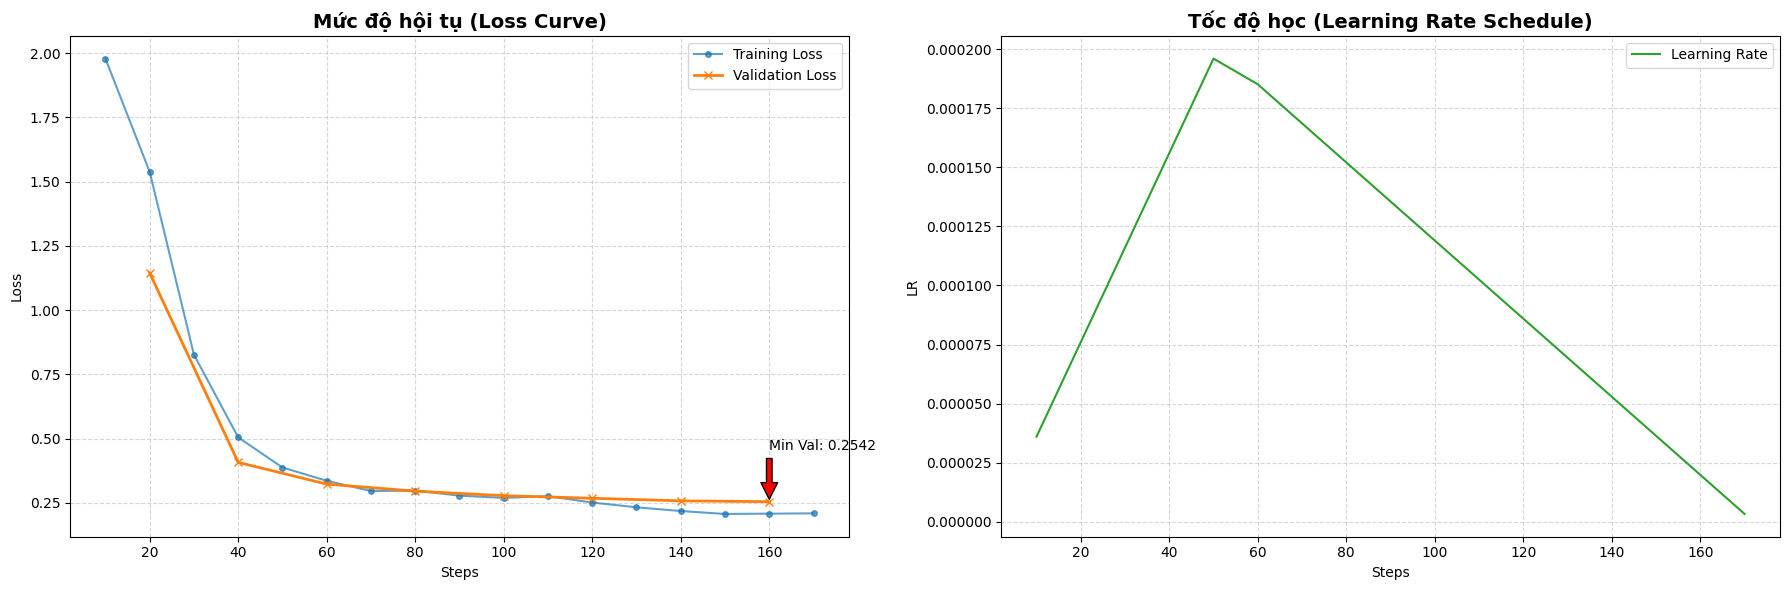


💡 PHÂN TÍCH NHANH:
✅ Tốt: Validation Loss vẫn đang giảm -> Mô hình đang học tốt.


In [ ]:
# --- [CODE MỚI 3] VẼ BIỂU ĐỒ THEO DÕI TOÀN DIỆN ---
import matplotlib.pyplot as plt
import numpy as np

# 1. TÍNH TOÁN TIÊU THỤ VRAM
used_memory = round(torch.cuda.max_memory_allocated() / 1024 / 1024 / 1024, 3)
used_percentage = round(used_memory / max_memory * 100, 2)
lora_memory = round(used_memory - start_gpu_memory, 3)

print(f"\n=== KẾT QUẢ TIÊU THỤ TÀI NGUYÊN ===")
print(f"VRAM tiêu thụ đỉnh điểm: {used_memory} GB ({used_percentage}%)")
print(f"VRAM dành riêng cho LoRA + Gradients: ~{lora_memory} GB")
print("="*60)

# 2. XỬ LÝ DỮ LIỆU LOG ĐỂ VẼ BIỂU ĐỒ
history = trainer.state.log_history

# Tách dữ liệu ra các list riêng biệt
train_steps = []
train_losses = []
eval_steps = []
eval_losses = []
lr_steps = []
learning_rates = []

for log in history:
    # Lấy dữ liệu Training Loss
    if "loss" in log and "step" in log:
        train_steps.append(log["step"])
        train_losses.append(log["loss"])
        # Lấy Learning Rate (thường đi kèm với log train)
        if "learning_rate" in log:
            lr_steps.append(log["step"])
            learning_rates.append(log["learning_rate"])

    # Lấy dữ liệu Validation Loss
    if "eval_loss" in log and "step" in log:
        eval_steps.append(log["step"])
        eval_losses.append(log["eval_loss"])

# 3. VẼ 2 BIỂU ĐỒ (LOSS & LEARNING RATE)
if len(train_steps) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # --- Biểu đồ 1: Training vs Validation Loss ---
    ax1.plot(train_steps, train_losses, label='Training Loss', color='#1f77b4', marker='o', markersize=4, alpha=0.7)
    if len(eval_steps) > 0:
        ax1.plot(eval_steps, eval_losses, label='Validation Loss', color='#ff7f0e', marker='x', markersize=6, linewidth=2)
        # Annotate Min Val Loss
        min_val_loss = min(eval_losses)
        min_val_step = eval_steps[eval_losses.index(min_val_loss)]
        ax1.annotate(f'Min Val: {min_val_loss:.4f}', xy=(min_val_step, min_val_loss),
                     xytext=(min_val_step, min_val_loss + 0.2),
                     arrowprops=dict(facecolor='red', shrink=0.05))

    ax1.set_title('Mức độ hội tụ (Loss Curve)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Loss')
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.legend()

    # --- Biểu đồ 2: Learning Rate Schedule ---
    ax2.plot(lr_steps, learning_rates, label='Learning Rate', color='#2ca02c', linestyle='-')
    ax2.set_title('Tốc độ học (Learning Rate Schedule)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('LR')
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Phân tích nhanh
    print("\n💡 PHÂN TÍCH NHANH:")
    if len(eval_losses) > 0:
        if eval_losses[-1] > min(eval_losses):
            print("⚠️ Cảnh báo: Validation Loss đang tăng trở lại -> Có dấu hiệu Overfitting nhẹ.")
        else:
            print("✅ Tốt: Validation Loss vẫn đang giảm -> Mô hình đang học tốt.")
    else:
        print("ℹ️ Chưa có dữ liệu Validation (Do số bước train < eval_steps).")
else:
    print("⚠️ Không tìm thấy dữ liệu Loss. Hãy kiểm tra lại quá trình train.")

In [ ]:
# # --- SỬA CELL 11 ---
# # Lưu đường dẫn vào biến để dùng lại
# save_path = OUTPUT_DIR + "/quy_che_chatbot_unsloth_merged"

# # Lưu Model (Merged 16bit để chạy inference ổn định)
# model.save_pretrained_merged(save_path, tokenizer, save_method = "merged_16bit")

# # Lưu Tokenizer riêng (đôi khi cần thiết để đảm bảo load đúng)
# tokenizer.save_pretrained(save_path)

# print(f"✅ Đã lưu model an toàn vào Google Drive: {save_path}")

In [ ]:
# # --- THAY THẾ TOÀN BỘ CELL 12 BẰNG CODE DƯỚI ĐÂY ---

# # 1. Bật chế độ tối ưu cho Inference (chạy nhanh gấp 2 lần)
# FastLanguageModel.for_inference(model)

# # 2. Định nghĩa hàm sinh câu trả lời
# def generate_response(question, input_text=""):
#     # Format Prompt chuẩn theo lúc train
#     alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

# ### Instruction:
# Bạn là trợ lý ảo hỗ trợ giải đáp quy chế đào tạo của Đại học Bách khoa Hà Nội.

# ### Input:
# {}

# ### Response:
# """
#     # Ghép câu hỏi vào prompt
#     prompt = alpaca_prompt.format(question)

#     # Tokenize
#     inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

#     # Generate
#     outputs = model.generate(
#         **inputs,
#         max_new_tokens=512,    # Độ dài tối đa câu trả lời
#         use_cache=True,
#         temperature=0.3,       # 0.3 giúp model ổn định, ít sáng tạo linh tinh
#         top_p=0.9,
#     )

#     # Decode kết quả
#     response = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
#     # Cắt bỏ phần Prompt, chỉ lấy phần Response
#     return response.split("### Response:")[-1].strip()

# # 3. Chạy so sánh Model trước và sau khi Fine-tune
# # Danh sách câu hỏi test (Nên chọn câu có trong quy chế HUST)
# test_questions = [
#     "Đại học Bách khoa Hà Nội xét tốt nghiệp mấy đợt trong năm?",
#     "Thời gian tối đa để sinh viên hoàn thành chương trình đào tạo là bao lâu?",
#     "Em bị cảnh báo học tập mức 2 thì có bị đuổi học không?"
# ]

# print(">>> BẮT ĐẦU SO SÁNH KẾT QUẢ <<<")

# for i, question in enumerate(test_questions):
#     print(f"\n{'='*20} TEST CASE {i+1} {'='*20}")
#     print(f"❓ Câu hỏi: {question}\n")

#     # --- TRƯỜNG HỢP A: Model ĐÃ Fine-tune ---
#     # Model hiện tại đang chứa Adapter LoRA nên mặc định là đã Fine-tune
#     print("🟢 [KẾT QUẢ ĐÃ FINE-TUNE] (Trợ giảng HUST):")
#     res_finetuned = generate_response(question)
#     print(res_finetuned)

#     # --- TRƯỜNG HỢP B: Base Model (Chưa Fine-tune) ---
#     # Dùng context manager 'disable_adapter()' để tạm thời tắt lớp LoRA
#     # Model sẽ hoạt động như Qwen2.5 gốc
#     print("\n🔴 [KẾT QUẢ BASE MODEL] (Qwen2.5 Gốc):")
#     with model.disable_adapter():
#         res_base = generate_response(question)
#         print(res_base)

#     print("-" * 60)

In [ ]:
# 1. Đăng nhập Hugging Face (Cần Token Write từ hf.co/settings/tokens)
from huggingface_hub import login
token_HuggingFace = userdata.get('HF_TOKEN')
login(token_HuggingFace) # Thay token của bạn vào đây

# 2. Đặt tên repository trên HF (Ví dụ: ten_ban/hust_chatbot_v1)
hf_repo_name = "wanduc0701/hust_chatbot_qwen2.5_finetuned"

# 3. Lưu và đẩy lên Hub (Dùng merged_16bit hoặc merged_4bit đều được)
# Khuyên dùng merged_16bit để giữ chất lượng tốt nhất, khi chạy thì load 4bit sau.
model.push_to_hub_merged(
    hf_repo_name,
    tokenizer,
    save_method = "merged_16bit",
    token = token_HuggingFace
)

print(f"✅ Đã đẩy model lên: https://huggingface.co/{hf_repo_name}")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ..._finetuned/tokenizer.json:  73%|#######2  | 8.30MB / 11.4MB            

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Checking cache directory for required files...
Cache check failed: model-00001-of-00004.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  25%|██▌       | 1/4 [01:50<05:32, 110.78s/it]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  50%|█████     | 2/4 [05:17<05:34, 167.36s/it]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  75%|███████▌  | 3/4 [07:35<02:33, 153.79s/it]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files: 100%|██████████| 4/4 [07:51<00:00, 117.94s/it]


Note: tokenizer.model not found (this is OK for non-SentencePiece models)


Unsloth: Merging weights into 16bit:   0%|          | 0/4 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...0001-of-00004.safetensors:   1%|          | 25.1MB / 4.88GB            

Unsloth: Merging weights into 16bit:  25%|██▌       | 1/4 [03:16<09:48, 196.13s/it]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...0002-of-00004.safetensors:   0%|          |  610kB / 4.93GB            

Unsloth: Merging weights into 16bit:  50%|█████     | 2/4 [06:35<06:36, 198.32s/it]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...0003-of-00004.safetensors:   0%|          |  609kB / 4.33GB            

Unsloth: Merging weights into 16bit:  75%|███████▌  | 3/4 [09:39<03:11, 191.72s/it]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...0004-of-00004.safetensors:   2%|2         | 25.2MB / 1.09GB            

Unsloth: Merging weights into 16bit: 100%|██████████| 4/4 [10:30<00:00, 157.50s/it]


Unsloth: Merge process complete. Saved to `/content/wanduc0701/hust_chatbot_qwen2.5_finetuned`
✅ Đã đẩy model lên: https://huggingface.co/wanduc0701/hust_chatbot_qwen2.5_finetuned
